In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import *
import matplotlib.pyplot as plt

Importing the Dataset and adding Variation to the dataset

In [3]:
training_transforms = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
]
)
test_transforms = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

In [4]:
#Basic training set that is used to train the data
training_data = datasets.MNIST(
    root = "data",
    train= True,
    download=True,
    transform= training_transforms
)

#Test data that can be used to test if NN is properly guessing the number
test_data = datasets.MNIST(
    root="data",
    train= False,
    download=True,
    transform=test_transforms,
)

test_data_image = datasets.MNIST(
    root="data",
    train = False,
    download=True,
)

Testing the functionality of dataset

7
(28, 28)


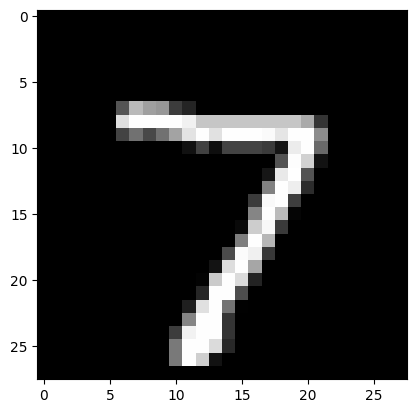

In [5]:
feature = test_data_image[0][0]
label = test_data_image[0][1]

print(label)
print(feature.size)
plt.imshow(feature, cmap='gray')

Creating the Batches that will get loaded into the model

In [6]:
batch_size = 64

train_dataLoader = DataLoader(training_data, batch_size= batch_size)
test_dataLoader = DataLoader(test_data, batch_size= batch_size)

for X, y in train_dataLoader:
    print(f"Shape of the X {X.shape}")
    print(f"Datatype and the shape of y {y.shape} {y.dtype}")
    break

Shape of the X torch.Size([64, 1, 28, 28])
Datatype and the shape of y torch.Size([64]) torch.int64


Creating the Model

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)     

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)


Optimizing the Model Parameters

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

This funtion will iterate and take the prediciton and then does backpropegation the prediction error to change and adjust the models parameters

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

This code will just test the model and see how well it is performing

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

This training process will then happen over epochs(iteration). It will print out the loss and then the accuracy in a form of a percent as well as the average loss.

In [55]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataLoader, model, loss_fn, optimizer)
    test(test_dataLoader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.044160  [   64/60000]
loss: 0.882452  [ 6464/60000]
loss: 0.963732  [12864/60000]
loss: 0.883089  [19264/60000]
loss: 0.802469  [25664/60000]
loss: 0.757086  [32064/60000]
loss: 0.810145  [38464/60000]
loss: 0.976272  [44864/60000]
loss: 0.847164  [51264/60000]
loss: 0.838503  [57664/60000]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.800140 

Epoch 2
-------------------------------
loss: 0.928981  [   64/60000]
loss: 0.767530  [ 6464/60000]
loss: 0.821441  [12864/60000]
loss: 0.780637  [19264/60000]
loss: 0.771798  [25664/60000]
loss: 0.717241  [32064/60000]
loss: 0.759507  [38464/60000]
loss: 0.887432  [44864/60000]
loss: 0.738479  [51264/60000]
loss: 0.844411  [57664/60000]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.740450 

Epoch 3
-------------------------------
loss: 0.897760  [   64/60000]
loss: 0.712961  [ 6464/60000]
loss: 0.840404  [12864/60000]
loss: 0.674915  [19264/60000]
loss: 0.799591  [25664/60000]
loss: 0.678641  [32064/600

In [56]:
torch.save(model.state_dict(), "model.pth") 

In [8]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [13]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
for i in range(20):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        featue = test_data_image[i][0]

Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"
Predicted: "1", Actual: "1"
Predicted: "0", Actual: "0"
Predicted: "4", Actual: "4"
Predicted: "1", Actual: "1"
Predicted: "4", Actual: "4"
Predicted: "4", Actual: "9"
Predicted: "6", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "6", Actual: "6"
Predicted: "9", Actual: "9"
Predicted: "0", Actual: "0"
Predicted: "1", Actual: "1"
Predicted: "5", Actual: "5"
Predicted: "9", Actual: "9"
Predicted: "7", Actual: "7"
Predicted: "3", Actual: "3"
Predicted: "4", Actual: "4"
